<h1>Day 3: Impact on AI & Security</h1>
<p><b>Workshop for the Computer Engineering Department, University of Tripoli</b></p>
<p><i>Prepared by Abdulmalek Baitulmal with Gemini</i></p>

## 🛠️ Setup: Installing a Stable & Consistent Qiskit Ecosystem

This cell installs the specific, compatible versions of the Qiskit libraries we need for today's hands-on applications to ensure a stable environment for everyone.

**Please run this cell, then RESTART THE KERNEL before proceeding.**

In [16]:
# Install specific, compatible library versions for this workshop
!pip install qiskit=='1.4.4' qiskit-aer qiskit-optimization qiskit-algorithms networkx pylatexenc

print("✅ Installation command executed.")
print("🔴 IMPORTANT: Please go to the 'Kernel' menu and select 'Restart Kernel' before running the next cell.")

✅ Installation command executed.
🔴 IMPORTANT: Please go to the 'Kernel' menu and select 'Restart Kernel' before running the next cell.


### Core Imports

Now we'll import all the tools we need for this session.

In [17]:
# Core Qiskit components
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT, EfficientSU2
from qiskit_aer.primitives import Sampler as AerSampler # V1-style AerSampler

# Qiskit Algorithms
from qiskit_algorithms.minimum_eigensolvers import SamplingVQE
from qiskit_algorithms.optimizers import SPSA

# Qiskit Optimization components
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer

# Other libraries
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import qiskit
import qiskit_algorithms
print(f"Qiskit Version: {qiskit.__version__}")
print(f"Qiskit Algorithms Version: {qiskit_algorithms.__version__}")

Qiskit Version: 1.4.4
Qiskit Algorithms Version: 0.4.0


## Part 1: Hands-On Cryptanalysis - Breaking "Toy" Encryption 🔐

This section demonstrates the core quantum subroutine of Shor's algorithm: period-finding.

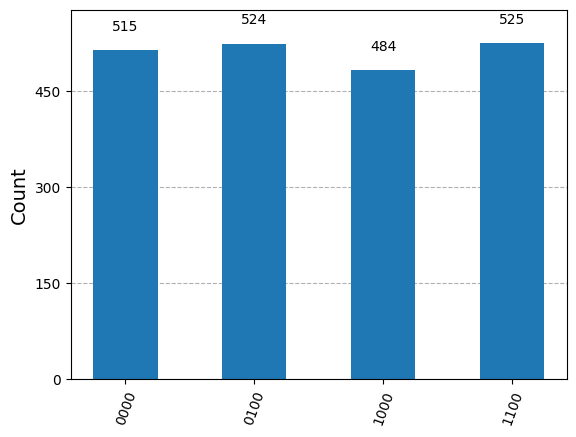

In [18]:
def c_amod15(a, power):
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2, 13]: U.swap(0, 1); U.swap(1, 2); U.swap(2, 3)
        if a in [7, 8]: U.swap(2, 3); U.swap(1, 2); U.swap(0, 1)
        if a in [4, 11]: U.swap(1, 3); U.swap(0, 2)
        if a in [7, 11, 13]:
            for q in range(4): U.x(q)
    U = U.to_gate(); U.name = f"{a}^{power} mod 15"; c_U = U.control()
    return c_U
n_count = 4; a = 7
qc = QuantumCircuit(n_count + 4, n_count)
qc.h(range(n_count)); qc.x(n_count)
for q in range(n_count): qc.append(c_amod15(a, 2**q), [q] + [i+n_count for i in range(4)])
qc.append(QFT(n_count, inverse=True), range(n_count))
qc.measure(range(n_count), range(n_count))
simulator = AerSimulator(); transpiled_qc = transpile(qc, simulator)
job = simulator.run(transpiled_qc, shots=2048); counts = job.result().get_counts()
display(plot_histogram(counts))

---

## Part 2: Hands-On Optimization - Advanced Resource Allocation 🧠

Let's tackle a more advanced and realistic optimization problem from telecommunications using the **Variational Quantum Eigensolver (VQE)**.

### The Problem: Constrained Multi-Resource Allocation

We have a scenario with multiple users and a limited set of resources (e.g., Frequency Bands). Our goal is to find the assignment that minimizes the total cost, subject to two conditions:

1.  **Each user must be assigned *exactly one* resource.**
2.  **There is an interference penalty if certain users are assigned the same resource.**

This is a computationally hard problem that scales exponentially. We will demonstrate the method on an 8-user, 3-resource problem, which requires 24 qubits.

In [19]:
# --- Problem Parameters ---
num_users = 8
num_resources = 3
np.random.seed(42)
assignment_costs = np.random.randint(1, 5, size=(num_users, num_resources))
interference_penalty = 10

# --- 1. Formulate the Problem as a Quadratic Program ---
qp = QuadraticProgram(name="Scaled-Resource-Allocation")
for i in range(num_users):
    for j in range(num_resources):
        qp.binary_var(name=f'x_{i}_{j}')

objective = {};
for i in range(num_users):
    for j in range(num_resources):
        objective[(f'x_{i}_{j}')] = assignment_costs[i, j]
for j in range(num_resources):
    for i1 in range(num_users):
        for i2 in range(i1 + 1, num_users):
             objective[(f'x_{i1}_{j}', f'x_{i2}_{j}')] = interference_penalty
qp.minimize(linear=objective.get('linear', {}), quadratic=objective.get('quadratic', {}))

for i in range(num_users):
    constraint_vars = {f'x_{i}_{j}': 1 for j in range(num_resources)}
    qp.linear_constraint(linear=constraint_vars, sense='==', rhs=1, name=f'user_{i}_constraint')

print(f"Quadratic Program created with {qp.get_num_vars()} variables.")

Quadratic Program created with 24 variables.


### 2. Configure and Run the VQE Solver

VQE is a hybrid algorithm. We use the high-level `MinimumEigenOptimizer` to wrap the entire process.

In [20]:
# 1. Define the VQE components
ansatz = EfficientSU2(num_qubits=qp.get_num_vars(), reps=2)
optimizer = SPSA(maxiter=100)
sampler = AerSampler() # Use the V1-compatible Sampler from Aer

# 2. Instantiate the VQE algorithm
vqe_solver = SamplingVQE(sampler=sampler, ansatz=ansatz, optimizer=optimizer)

# 3. Create the high-level MinimumEigenOptimizer
vqe_optimizer = MinimumEigenOptimizer(min_eigen_solver=vqe_solver)

print("Running VQE... This will take a significant amount of time for 24 qubits.")
result = vqe_optimizer.solve(qp)
print("VQE has finished!")

print("\n--- Optimal Resource Allocation ---")
for i in range(num_users):
    for j in range(num_resources):
        if result.x[i * num_resources + j] == 1:
            print(f"User_{i}  ->  Resource_{j}")
print(f"\nTotal Minimized Cost: {result.fval}")

Running VQE... This will take a significant amount of time for 24 qubits.


TypeError: Invalid circuits, expected Sequence[QuantumCircuit].

---

## Part 3: Hands-On Secure Communication - Simulating QKD 🌐

Let's simulate the famous **BB84 Quantum Key Distribution** protocol to see how we can use physics to securely share a secret key.

In [ ]:
# Let's simulate sharing a short 16-bit key
key_length = 16
np.random.seed(0)

# 1. Alice prepares her bits and bases
alice_key = np.random.randint(2, size=key_length)
alice_bases = np.random.randint(2, size=key_length) # 0 for Z-basis, 1 for X-basis

def encode_message(key_bits, bases):
    message = []
    for i in range(len(key_bits)):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: # Prepare in Z-basis
            if key_bits[i] == 1:
                qc.x(0)
        else: # Prepare in X-basis
            if key_bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        message.append(qc)
    return message

alice_message = encode_message(alice_key, alice_bases)

# 2. Bob chooses his bases and measures
bob_bases = np.random.randint(2, size=key_length)

def measure_message(message, bases):
    backend = AerSimulator()
    measurements = []
    for i in range(len(bases)):
        if bases[i] == 0: # Measure in Z-basis
            message[i].measure(0,0)
        else: # Measure in X-basis
            message[i].h(0)
            message[i].measure(0,0)

        transpiled_qc = transpile(message[i], backend)
        result = backend.run(transpiled_qc, shots=1, memory=True).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

bob_results = measure_message(alice_message, bob_bases)

# 3. Alice and Bob sift their keys
final_key = []
for i in range(key_length):
    if alice_bases[i] == bob_bases[i]:
        final_key.append(bob_results[i])

print(f"Alice's original key:  {alice_key}")
print(f"Alice's bases:         {alice_bases}")
print(f"Bob's bases:           {bob_bases}")
print(f"Bob's results:         {bob_results}")
print(f"Agreed upon secret key: {final_key}")
print(f"Key Length: {len(final_key)} bits")